# Gaussian texture synthesis and mixing

Synthesizing new images using Gaussian models is probably the most basic idea in image synthesis. However, even if it is simple, this framework is already very rich and allows many nice recipes, going from texture synthesis to texture inpainting and texture mixing. The general model is simple and explicit, but has also many subtleties, when dealing for instance with the image boundaries or color images.

This practical session shows how to obtain texton and Gaussian synthesis of color and gray textures, as well as texture mixing.

**Authors:**
- Lucía Bouza
- [Agnès Desolneux](https://desolneux.perso.math.cnrs.fr)

## Importing packages

Below is a list of packages needed to implement the algorithms.

* `Numpy`
* `PIL.Image, matplotlib.pyplot` (display of images and graphics)
* `os` (interactions with the operating system)
* `widgets` (display result of Gaussian texture mixing)

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from google.colab import widgets

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [3]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/Solutions/GausianTSandMixing.py")
#from GausianTSandMixing import *

## Helper functions

Import the helper functions for loading and displaying images by running the cell below.

In [4]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/AuxiliarFunctions/gaussianTSandMixing.py")
from gaussianTSandMixing import *

## Loading images

In the next section we will upload texture images. Not all texture images are well represented by Gaussian models. Only the so-called micro-textures are. When the geometric content is strongly constrained, the Gaussian model is not able to capture it.

Try running the exercises with micro-textures, but also with regular textures like *grapes.jpg* or *tannat.jpg* to see the difference.

In [5]:
texture_imgnames = ["bois.png", "mur.png", "tissu.png", "nuages.png","wall1003.png", "tulum.jpg", "grapes.jpg", "tannat.jpg"]

for fname in texture_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Textures/"+fname)
    img = Image.open(fname)

In this cell we choose the texture for the next exercise. We can choose from the images uploaded in the previous cell, by changing the parameter of the `loadImage` function. Once we have the image, we will also generate its grayscale version.

<Figure size 640x480 with 0 Axes>

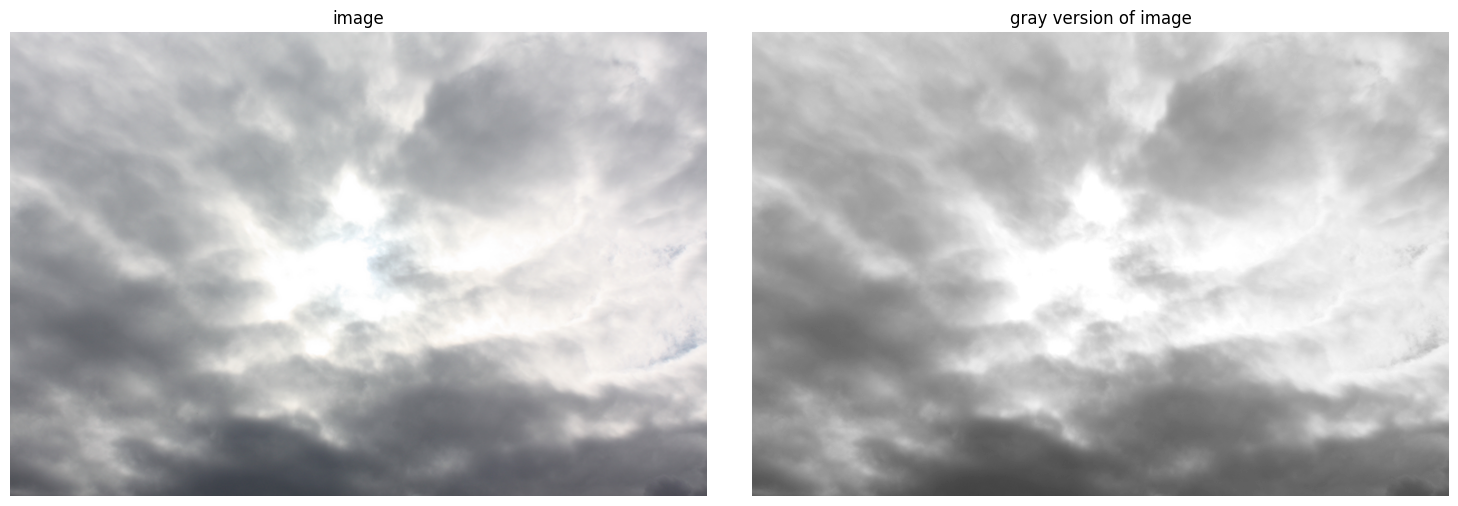

<Figure size 640x480 with 0 Axes>

In [6]:
u = loadImage("nuages.png")

# Convert image to gray-scale
u_gray =  0.13*u[:,:,0] + 0.5*u[:,:,1] + 0.37*u[:,:,2]

# Plot both images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].imshow(u)
axes[0].set_title('image')
axes[0].axis('off')
axes[1].imshow(u_gray,cmap='gray',vmin=0,vmax=1)
axes[1].set_title('gray version of image')
axes[1].axis('off')
fig.tight_layout()
plt.figure()

## 1. Periodic plus smooth image decomposition

### Underlying principle
The Fourier transform of an image is very sensitive to its discontinuities. By applying the transformation, it makes the implicit assumption that the image is somehow “periodic”. However, an image is generally not periodic and the left/right borders (resp. top/bottom) of the image don’t "coincide". As a result, a "cross" appears in the image of the amplitude of the Fourier transform.

To remove this artifact, Lionel Moisan proposed in [1] to consider the decomposition of an image $u$ into $u = p + s$,
where $p$ is the periodic component and $s$ is the smooth component. $p$ will have almost the same Fourier transform as $u$, without the cross effect due to the non-periodic boundaries of $u$.

The periodic component $p$ of $u$ defined over a domain $\Omega$ is defined to be the unique solution of:

$$
\begin{cases}
\Delta p = \Delta_i u \\
mean(p) = mean(u)
\end{cases}
$$

The Laplacian $\Delta$ of an image $f$ defined over a domain $\Omega$ can be defined as:

$$ \Delta f(x) = 4f(x) - \sum_{y \in N_x} f(y) $$

where $N_x$ denote the neighborhood of $x \in \Omega$ for 4-connectivity.

The Laplacian $\Delta_i$ (here index $i$ means “interior”) of an image $f$ defined over a domain $\Omega$ can be defined as:

$$ \Delta_i f(x) = |N_x \cap \Omega|f(x) - \sum_{y \in N_x \cap \Omega} f(y)$$

[1] Lionel Moisan. "Periodic plus smooth image decomposition." Journal
of Mathematical Imaging and Vision 39.2 (2011): 161-179.

### Procedure to compute periodic and smooth component

$s = u − p$ is “smooth”: its Laplacian is equal to $0$ except at the boundary. It's known that when $s$ is extended by periodicity, we have in the Fourier domain:

$$ \forall \xi \in \Omega, \;  \widehat{\Delta s}(\xi) = \left( 2 \cos \left(2\pi\langle e_1,\xi \rangle \right) + 2 \cos \left( 2\pi \langle e_2, \xi \rangle \right) - 4 \right) \widehat{s}(\xi)$$

Also, as $s = u − p$, we have:

$$ \Delta s = \Delta u - \Delta p = \Delta u - \Delta_i u:= B(u) $$

We can compute the “boundary discontinuity” $B(u)$ using the definitions of the Laplacian and the interior Laplacian by:

$$ \forall x \in \Omega,\;  B(u)(x) = \sum_{y \in N_x \cap \Omega^c} \left( u(y) - u (x) \right)$$

where $\Omega^c$ denote the complementary set of $\Omega \in \mathbb{Z}^2$ and $u$ is extended to $\mathbb{Z}^2$ by periodicity.

Therefore:

$$ \widehat{\Delta s} = \widehat{B}(u) = \left( 2 \cos \left(2\pi\langle e_1,\xi \rangle \right) + 2 \cos \left( 2\pi \langle e_2,\xi \rangle \right) - 4 \right) \widehat{s}(\xi) $$

and then:

$$\widehat{s}(\xi) = \frac{\widehat{B(u)}(\xi)}{  2 \cos \left(2\pi\langle e_1,\xi \rangle \right) + 2 \cos \left( 2\pi \langle e_2,\xi \rangle \right) - 4 } $$

Only the mean value of the image can not be recovered from its Laplacian, so  $\widehat{s}(0) = 0$. Finally the periodic component can be computed as $p = u − s$.

**Excercise 1**. Write a function `ppluss` that takes as input a gray-scale image $u$ and then computes its periodic and smooth components.

In [7]:
def ppluss(u_gray):

    Omega_x = np.arange(0,1,1/u_gray.shape[1])[None, :]
    Omega_y = np.arange(0,1,1/u_gray.shape[0])[:, None]

    Omega_x = np.repeat(Omega_x, u_gray.shape[0], axis = 0)
    Omega_y = np.repeat(Omega_y, u_gray.shape[1], axis = -1)

    #Boundary discontinuity
    B = np.zeros(u_gray.shape)

    B[0,:] = u_gray[0,:] - u_gray[-1,:]
    B[-1,:] = u_gray[-1,:] - u_gray[0,:]
    B[:,0] = u_gray[:,0] - u_gray[:,-1]
    B[:,-1] = u_gray[:,-1] - u_gray[:,0]

    B[0,0] = 2*u_gray[0,0] - u_gray[0,-1] - u_gray[-1,0]
    B[-1,-1] = 2*u_gray[-1,-1] - u_gray[0,-1] - u_gray[-1,0]
    B[0,-1] = 2*u_gray[0,-1] - u_gray[-1,-1] - u_gray[0,0]
    B[-1,0] = 2*u_gray[-1,0] - u_gray[-1,-1] - u_gray[0,0]

    fft_B = np.fft.fft2(-B)
    fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)
    fft_s[0,0] = 0

    s = np.fft.ifft2(fft_s).real

    return u_gray - s, s

In [8]:
P,S = ppluss(u_gray)

<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: invalid value encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)


In [9]:
def printImages(u_gray, P, S):
    # Plot both images
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
    axes[0].imshow(u_gray, cmap = 'gray', vmin = 0, vmax = 1)
    axes[0].set_title('Original gray image', fontsize = 7)
    axes[0].axis('off')
    axes[1].imshow(P, cmap='gray', vmin = 0, vmax = 1)
    axes[1].set_title('Periodic component', fontsize = 7)
    axes[1].axis('off')
    axes[2].imshow(S, cmap='gray')
    axes[2].set_title('Smooth component', fontsize = 7)
    axes[2].axis('off')
    fig.tight_layout()
    plt.figure()

def printFTImages(u_gray, P, S, nx, ny):
    # Plot both images
    fft_u_gray = np.fft.fftshift(np.abs(np.fft.fft2(u_gray)))
    fft_P = np.fft.fftshift(np.abs(np.fft.fft2(P)))
    fft_S = np.fft.fftshift(np.abs(np.fft.fft2(S)))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 8))
    axes[0].imshow(20*np.log(fft_u_gray), cmap = 'gray', vmin=0, vmax=255)
    axes[0].set_title('Fourier transform image', fontsize = 7)
    axes[0].axis('off')
    axes[1].imshow(20*np.log(fft_P), cmap='gray',  vmin=0, vmax=255)
    axes[1].set_title('Fourier transform Periodic component', fontsize = 7)
    axes[1].axis('off')
    axes[2].imshow(20*np.log(fft_S), cmap='gray',  vmin=0, vmax=255)
    axes[2].set_title('Fourier transform Smooth component', fontsize = 7)
    axes[2].axis('off')
    fig.tight_layout()
    plt.figure()


Below we show the original image, the perioric component and the smooth component, and their corresponding Fourier transform.

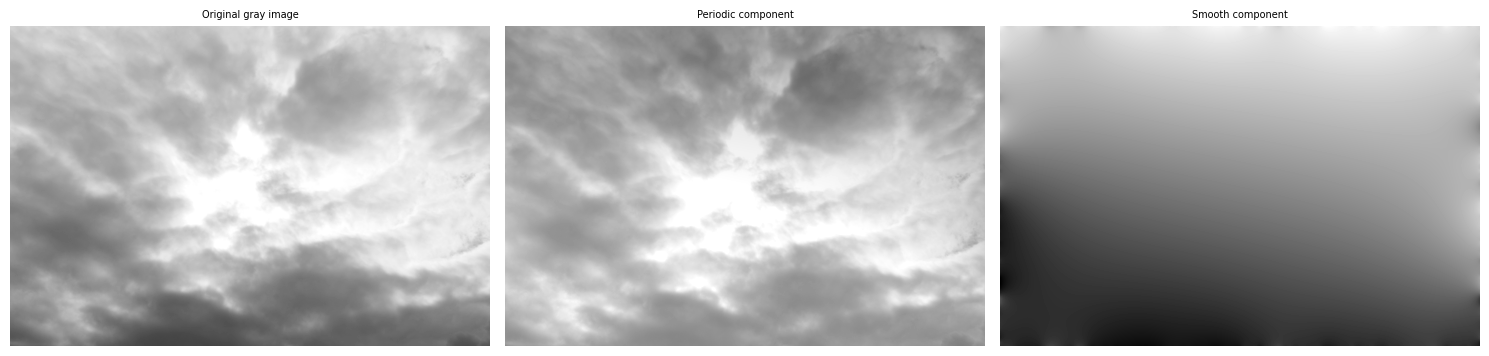

<Figure size 640x480 with 0 Axes>

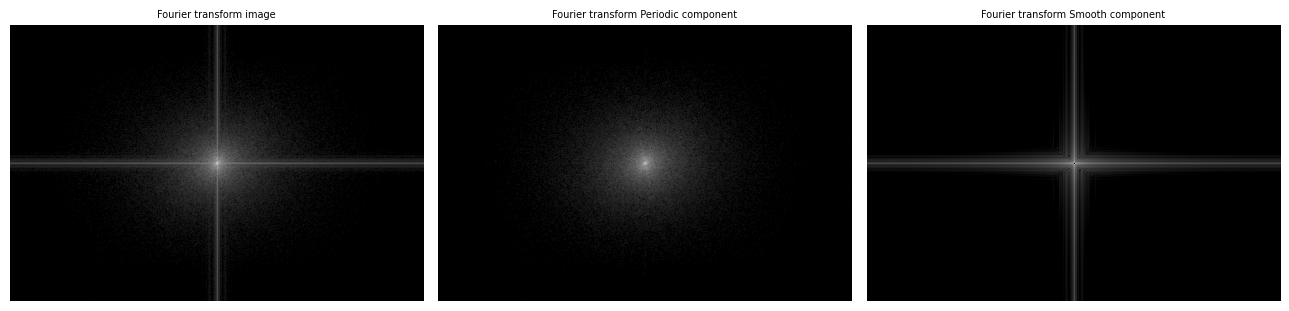

<Figure size 640x480 with 0 Axes>

In [10]:
printImages(u_gray, P, S)
printFTImages(u_gray, P, S, 20, 20)

## 2. Gray-level image: texton and Gaussian synthesis

In this section we will compute the texton of a gray-scale texture and then generate a Gaussian texture synthesis from it. For the exercise we will use the periodic component of the selected original texture, therefore we must start with the first task, to fulfill all the prerequisites.


**Excercise 1**. Write a function `ChangeToPeriodic` that takes as input gray-scale image $u_0$ of size $n_h × n_w$. Replace $u_0$ with its periodic component. Compute its empirical mean $m_{u_0}$ and remove $m_{u_0}$ from the image to have a zero-mean image $u_0$. Return the new image and $m_{u_0}$ (we must keep $m_{u_0}$ to add it to the Gaussian Synthesis at the end).

You can verify that the mean of the original image and of its periodic component are the same, so the order to compute the mean doesn't affect the results.

In [11]:
# Load image and convert it to gray-scale
u = loadImage("mur.png")
u_gray =  0.33*u[:,:,0] + 0.5*u[:,:,1] + 0.17*u[:,:,2]

def ChangeToPeriodic(u_gray):
    P,_ = ppluss(u_gray)
    m = np.mean(P)
    return P - m, m

u_gray_processed, mean_u_gray = ChangeToPeriodic(u_gray)

<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: invalid value encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)


Next we plot the histograms of the original gray-scale image and of the processed image obtained after application of the `ChangeToPeriodic` function (periodic component of the original image with mean removed).

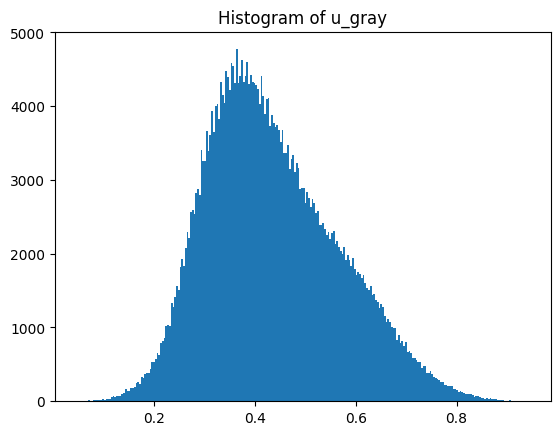

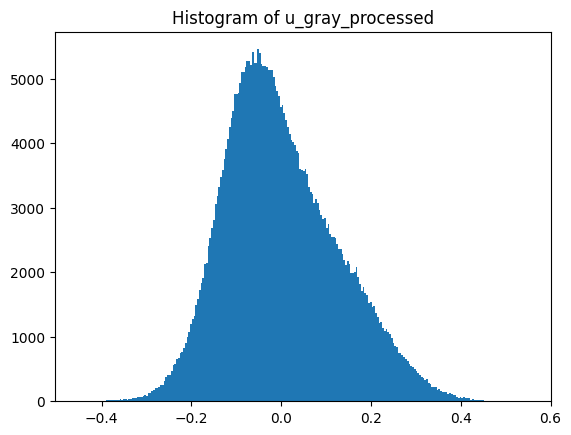

In [12]:
# Histogram of u_gray
Y = np.reshape(u_gray, u_gray.shape[0]*u_gray.shape[1])
plt.hist(Y,256)
plt.title('Histogram of u_gray')
plt.show()

# Histogram of u_gray_processed
X = np.reshape(u_gray_processed, u_gray_processed.shape[0]*u_gray_processed.shape[1])
plt.hist(X,256)
plt.title('Histogram of u_gray_processed')
plt.show()


### Texton

Let $u_0$ be an image defined on $\Omega$ with zero mean and periodic. The texton $T(u_0)$ of $u_0$ is the image defined on $\Omega$ such that the fourier transform of $T(u_0)$ is equal to the modulus of the fourier transform of $u_0$.

$$ \widehat{T(u_0)} = | \widehat{u_0}| $$

**Excercise 2**. Compute and visualize the texton $T(u_0)$ of $u_0$, placing 0 in the center of the image. To better see the concentration of the texton, draw the signals $x  \rightarrow T(u_0)(x,0)$ and $y \rightarrow T(u_0)(0,y)$, which are two slices of the texton image passing through the origin.

In [50]:
def ComputeTexton(u_gray_processed):
    return np.fft.ifft2(np.abs(np.fft.fft2(u_gray_processed))).real

def printGrayTexton(real_STI, mean_u_gray):
    real_STI = np.fft.fftshift(real_STI) + mean_u_gray #center the image
    plt.imshow(real_STI, cmap = 'gray', vmin = 0, vmax = 1)
    plt.axis('off')

def PlotSlices(u_gray):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))
    axes[0].plot(np.arange(u_gray.shape[1]), np.roll(u_gray[0], np.arange(u_gray.shape[1])//2), label = 'Slice along x-axis')
    axes[1].plot(np.arange(u_gray.shape[0]), np.roll(u_gray[:,0], np.arange(u_gray.shape[0])), label = 'Slice along y-axis')

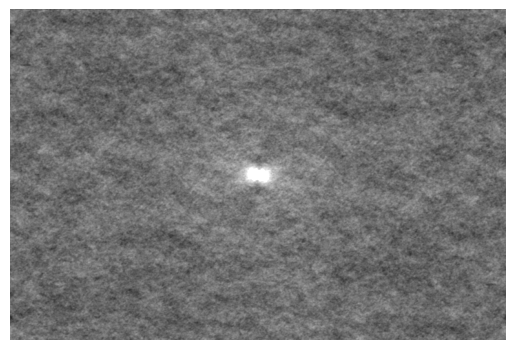

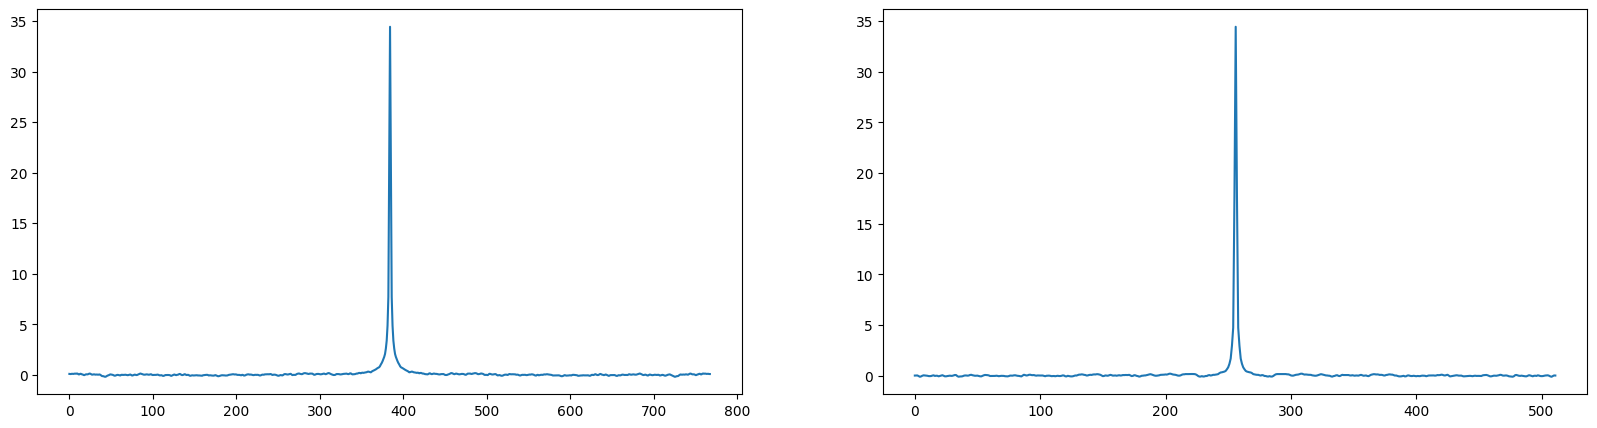

In [14]:
# Compute Texton
STI = ComputeTexton(u_gray_processed)

# Plot Texton placing 0 at the center of the image.
real_STI = np.real(STI)
printGrayTexton(real_STI, mean_u_gray)
# Plot Slices
PlotSlices(real_STI)

### Gaussian synthesis

Consider $u_0$ an image with zero mean defined on $\Omega$  and $W$ a white noise image of variance $σ^2 = \frac{1}{|\Omega|}$ on $\Omega$. The random image $U = u_0 ∗ W$ follows a stationary Gaussian distribution that has zero mean and the same empirical covariance as $u_0$ .

We will use the texton to compute the image synthesis. It is possible to compute a synthesis larger than the original image. To compute a synthesis $v$ in $\Omega'$ ($\Omega'$ can be the same as $\Omega$ or even larger) the steps are:

- Generate a white noise image $W$ on $\Omega'$ of variance $σ^2 = \frac{1}{|\Omega'|}$.
- Place $T(u_0)$ (size $\Omega$) at the center of $\Omega'$ and extend it to $\Omega'$ by 0. Let's call this new image $T(u_0)'$
- Normalize $T(u_0)'$ to have the same empirical variance. $T(u_0)' = T(u_0)' \frac{\sqrt{|\Omega'|}}{\sqrt{|\Omega|}}$
- Get the Fourier transform of the synthesis $v$ as: $\widehat{v} = \widehat{T(u_0)'}\widehat{W}$.
- To get the synthesis $v$, take the inverse Fourier transform of $\widehat{v}$ and add the mean value of the original image.

Note that the normalization step can be eliminated if the noise is generated with variance $σ^2 = \frac{1}{|\Omega|}$.


**Excercise 3**. Generate two Gaussian textures using the texton computed on excercise 2: the first one of size $n_h × n_w$ and the second one of size $2n_h × 2n_w$.

In [15]:
#Compute the Texon
def GenerateGaussianTexture(STI, mean_u_gray):
    dim = np.prod(STI.shape)
    white_noise = np.random.randn(STI.shape[0], STI.shape[1])*1/np.sqrt(dim)
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(STI)*np.fft.fft2(white_noise)).real) + mean_u_gray

#Compute the Texon
def GenerateGaussianTextureDouble(STI, mean_u_gray):
    dimp = 4*np.prod(STI.shape)
    dim = np.prod(STI.shape)

    white_noise = np.random.randn(STI.shape[0]*2, STI.shape[1]*2)/np.sqrt(dimp)

    STI_exp = np.zeros((STI.shape[0]*2, STI.shape[1]*2), dtype = 'complex')
    STI_exp[:STI.shape[0], :STI.shape[1]] = STI
    STI_exp *= np.sqrt(dimp)/np.sqrt(dim)
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(STI_exp)*np.fft.fft2(white_noise)).real) + mean_u_gray


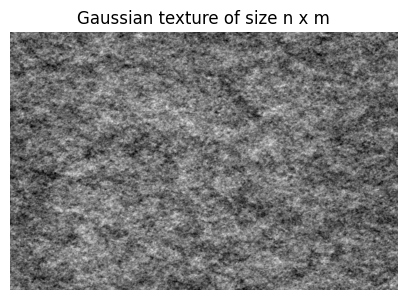

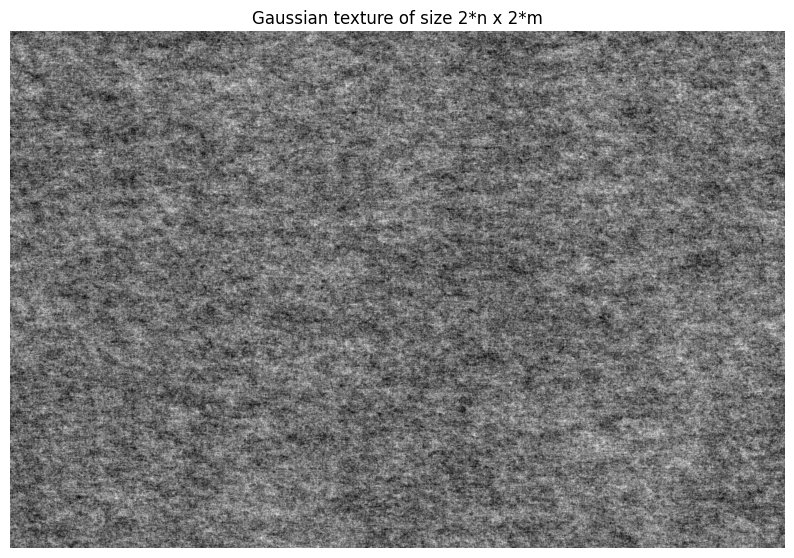

In [76]:
Gaussian_texture = GenerateGaussianTexture(STI, mean_u_gray)
Gaussian_texture_2 = GenerateGaussianTextureDouble(STI, mean_u_gray)

# Plot both Textures
PlotTextures(Gaussian_texture, Gaussian_texture_2)

## 3. Color image: texton and Gaussian synthesis

In this section we will compute the texton of a color texture and then generate a Gaussian texture synthesis from it. For the exercise we will use the periodic component of the selected original texture, therefore we must start with the first task, to fulfill all the prerequisites.

**Excercise 1**. Take a color image $u_0$ of size $n_h × n_w$. Replace it by its periodic component (i.e. replace each channel by its periodic component). Compute its empirical mean $m_{u_0} \in \mathbb{R}^3$ and remove it from the image to have a zero-mean color image. Return the new image and $m_{u_0}$ (we must keep $m_{u_0}$ to add it to the Gaussian Synthesis at the end).

In [17]:
u = loadImage("mur.png")

def ChangeToPeriodic_Color(u):
    P_r,_ = ppluss(u[:,:,0])
    P_g,_ = ppluss(u[:,:,1])
    P_b,_ = ppluss(u[:,:,2])

    P_r = np.expand_dims(P_r, axis = -1)
    P_g = np.expand_dims(P_g, axis = -1)
    P_b = np.expand_dims(P_b, axis = -1)

    m_r = [np.mean(u[:,:,0])]
    m_g = [np.mean(u[:,:,1])]
    m_b = [np.mean(u[:,:,2])]

    return np.concatenate((P_r, P_g, P_b), axis = -1), np.concatenate((m_r, m_g, m_b))

u_processed, mean_u= ChangeToPeriodic_Color(u)

<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: invalid value encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)


Next we plot the histograms of the first channel of the color image and the first channel of the processed image by the function `ChangeToPeriodic_Color`.

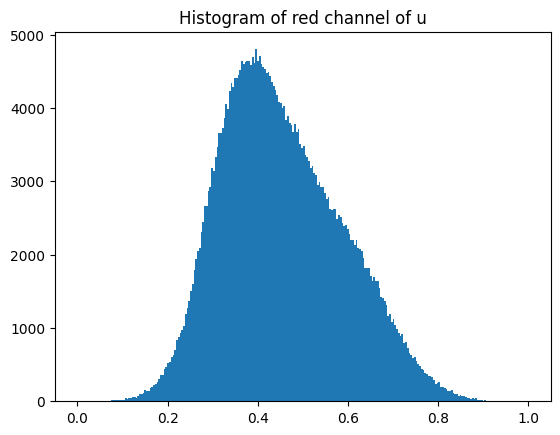

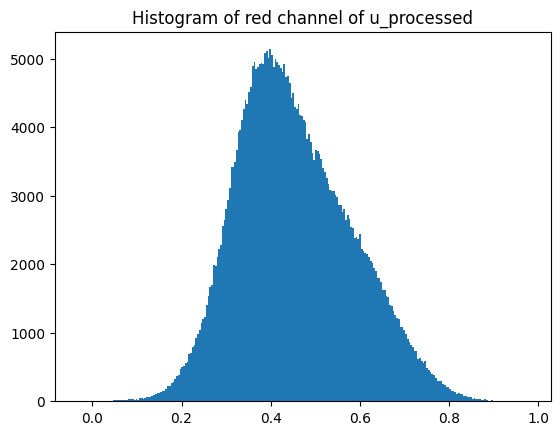

In [18]:
# Histogram of u
Y = np.reshape(u[:,:,0], u.shape[0]*u.shape[1])
plt.hist(Y, bins= 256, range=(0,1))
plt.title('Histogram of red channel of u')
plt.show()

# Histogram of u_processed
X = np.reshape(u_processed[:,:,0], u_processed.shape[0]*u_processed.shape[1])
plt.hist(X, bins = 256)
plt.title('Histogram of red channel of u_processed')
plt.show()

### Texton

When $u$ is a color image, the texton $T(u)$ can be obtained by substracting the same phase from all three channels, this phase being that of a linear combination of the channels.

More precisely, if $u = (u^R,u^G,u^B)$ is a color image defined on $\Omega$, for any $α = (\alpha^R,\alpha^G,\alpha^B) \in \mathbb{R}^3$, one can define the $\alpha$-texton of $u$ by the color image $T_\alpha(u) = (T_\alpha(u)^R,T_\alpha(u)^G,T_\alpha(u)^B) $ where for any color channel $c \in \{R,G,B\}$,

$$ \forall \xi \in \Omega, \; \widehat{T_\alpha(u)^c}(\xi) = \widehat{u^c}(\xi)e^{-i\phi_{\alpha.u}(\xi)} $$

where $\phi_{\alpha.u}(\xi)$ is the phase of $\widehat{\alpha.u}(\xi)$, and the image $\alpha\cdot u = \alpha^Ru^R + \alpha^Gu^G + \alpha^Bu^B $ being a real-valued image.

So, a way to obtain the texton is:

- Compute the image $\alpha.u$ as a lineal combination of the three channels of $u$. If we use $\alpha = (0.33, 0.5, 0.17)$ leads to the luminance channel of $u$.  
- Compute the phase of the Fourier transform of $\alpha\cdot u$, and scale it by the modulus.
- Change the sign of the imaginary part with the complex conjugate. Let's call it "Phase Opposite".
- Compute the inner product between the "Phase Opposite" and the fourier transform of each channel of $u$.
- Compute it's inverse fourier transform to obtain the Texton.


**Excercise 2**. Compute and visualize the color texton image $T_\alpha(u)$ for instance with $\alpha = (0.33, 0.5, 0.17)$ (the luminance channel), placing 0 in the center of the image.

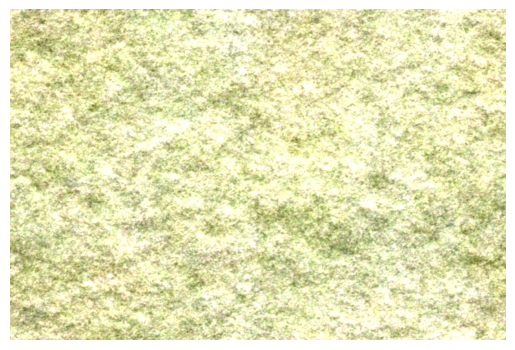

In [94]:
def ComputeTexton_Color(u_processed):
  alpha = [0.33, .5, .17]
  u_gray = u_processed[:,:,0]*alpha[0] + u_processed[:,:,1]*alpha[1] + u_processed[:,:,2]*alpha[2]
  fft_u_gray = np.fft.fft2(u_gray)

  phase = np.exp(-1j*np.angle(fft_u_gray))

  T_r = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(u_processed[:,:,0])*np.conj(phase)).real[:,:,None])
  T_g = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(u_processed[:,:,1])*np.conj(phase)).real[:,:,None])
  T_b = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(u_processed[:,:,2])*np.conj(phase)).real[:,:,None])

  return np.concatenate((T_r, T_g, T_b), axis = -1)

# Compute Texton
STI_color = ComputeTexton_Color(u_processed)

# Plot Texton placing 0 at the center of the image.
real_STI_color = np.real(STI_color)
printColorTexton(real_STI_color, mean_u)

### Gaussian synthesis

**Excercise 3**. Generate a Gaussian color texture synthesis of size $n_h × n_w$ using the texton computed on exercise 2. To implement it, apply the same idea of Gray-scale synthesis to each channel, but use the same white noise for all.

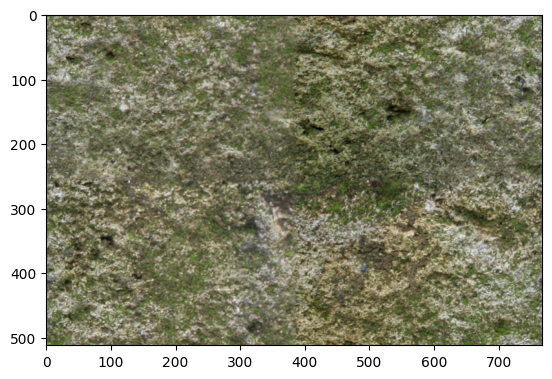

In [25]:
plt.imshow(STI_color)

(-0.5, 767.5, 511.5, -0.5)

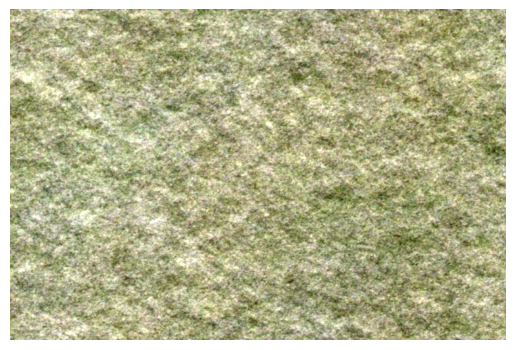

In [28]:
def GenerateGaussianTexture_Color(STI_color, mean_u):
    dim = np.prod(STI_color.shape[:2])
    white_noise = np.random.randn(STI_color.shape[0], STI_color.shape[1])/np.sqrt(dim)

    STI_r = STI_color[:,:,0]
    STI_g = STI_color[:,:,1]
    STI_b = STI_color[:,:,2]

    STI_r = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(STI_r)*np.fft.fft2(white_noise)).real) + mean_u[0]
    STI_g = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(STI_g)*np.fft.fft2(white_noise)).real) + mean_u[1]
    STI_b = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(STI_b)*np.fft.fft2(white_noise)).real) + mean_u[2]

    STI_r = STI_r[:,:,None]
    STI_g = STI_g[:,:,None]
    STI_b = STI_b[:,:,None]

    return np.concatenate((STI_r,STI_g,STI_b), axis = -1)

Gaussian_texture_color = GenerateGaussianTexture_Color(STI_color, mean_u)
plt.imshow(np.clip(np.real(Gaussian_texture_color),0,1))
plt.axis('off')

## 4. Gaussian texture mixing




### Gray-scale texture mixing

Let $u_0$ and $u_1$ be two gray-scale images defined on the same domain $\Omega$. Let $GT(u_0)$ and $GT(u_1)$ be their respective Gaussian texture model. The 2-Wasserstein distance between $GT(u_0)$ and $GT(u_1)$ can be defined as:

$$ W^2_2(GT(u_0),GT(u_1)) = \| m_{u_0} - m_{u_1}\|^2 + \frac{1}{\Omega} \sum_{\xi \neq 0} (|\widehat{u_0}(\xi)| - |\widehat{u_1}(\xi)|)^2 \\ = |\Omega| (( m_{u_0} - m_{u_1} )^2 + \|T(u_0 - m_{u_0}) - T(u_1 - m_{u_1}) \|^2)$$

where $T(u_i −m_{u_i})$ is the texton of the zero mean version of $u_i$, for i = 0 or 1.

Moreover if $\rho \in [0, 1]$, then the barycenter between $GT(u_0)$ and $GT(u_1)$ with weights $(1 − \rho, \rho)$ is given by the Gaussian texture model $GT(u_\rho)$ with

$$ u_\rho =(1−\rho)(m_{u_0} +T(u_0 −m_{u_0}))+ \rho( m_{u_1} +T(u_1 −m_{u_1})) $$

**Exercise 1**. Take two gray-scale images $u_0$ and $u_1$ of same size $n_h × n_w$. Compute their mean, remove it and replace each image by its periodic component. Then generate a sequence of $n_\rho + 1$ (with $n_\rho$ = 5 for instance) texture images from the Wasserstein barycenter Gaussian texture model $GT(u_\rho)$, for $\rho = 0, \frac{1}{n_p} , \frac{2}{n_p} , . . . , 1$.

<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: invalid value encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

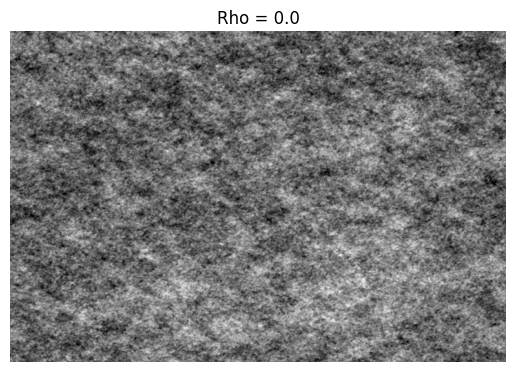

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

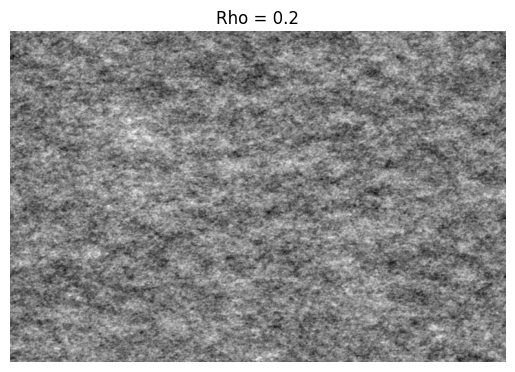

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

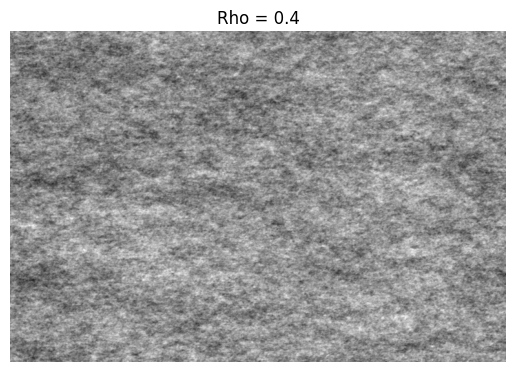

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

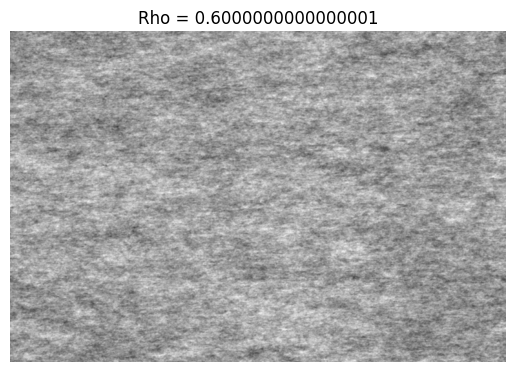

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

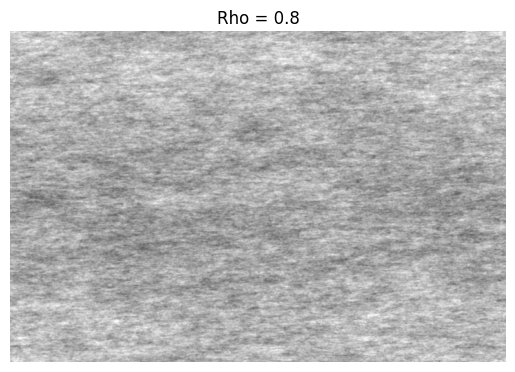

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

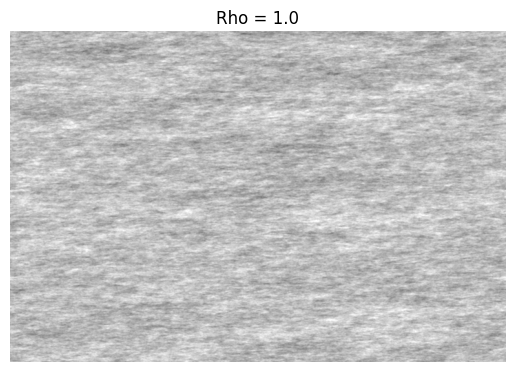

<IPython.core.display.Javascript object>

In [86]:
# Load image and convert it to gray-scale
u = loadImage("mur.png")
u_0_gray =  0.33*u[:,:,0] + 0.5*u[:,:,1] + 0.17*u[:,:,2]

u_1 = loadImage("tulum.jpg")
u_1_gray =  0.21*u_1[:,:,0] + 0.72*u_1[:,:,1] + 0.07*u_1[:,:,2]
u_1_gray = u_1_gray[:u_0_gray.shape[0], :u_0_gray.shape[1]]

# Rho
n_p = 5

def GaussianTextureMixing_gray(u_0_gray, u_1_gray, n_p):
  rho = [i/n_p for i in range(n_p + 1)]

  #Take the periodic component
  u_0_processed, mean_u0 = ChangeToPeriodic(u_0_gray)
  u_1_processed, mean_u1 = ChangeToPeriodic(u_1_gray)

  #Compute the Texon
  STI_0 = ComputeTexton(u_0_processed)
  STI_1 = ComputeTexton(u_1_processed)

  return [GenerateGaussianTexture((rh*STI_0 + (1-rh)*STI_1), rh*mean_u0 + (1-rh)*mean_u1) for rh in rho]

# Get a list of texture mixing with differents values of rho
GTrho_list = GaussianTextureMixing_gray(u_1_gray, u_0_gray, n_p)

# Compare images
compare_images(GTrho_list, n_p, gray=True)

### Color texture mixing

Let $u_0$ and $u_1$ be two color images defined on the same domain $\Omega$. Let $GT(u_0)$ and $GT(u_1)$ be their respective Gaussian texture model. The 2-Wasserstein distance between $GT(u_0)$ and $GT(u_1)$ can be defined as:

$$ W^2_2(GT(u_0),GT(u_1)) = \| m_{u_0} - m_{u_1}\|^2 + \frac{1}{\Omega} \sum_{\xi \neq 0} ( \|\widehat{u_0}(\xi)\|^2 + \|\widehat{u_1}(\xi)\|^2 -2|\widehat{u_0}(\xi)^*\widehat{u_1}(\xi)| )$$

Moreover if $\rho \in [0, 1]$, then the barycenter between $GT(u_0)$ and $GT(u_1)$ with weights $(1 − \rho, \rho)$ is given by the Gaussian texture model $GT(u_\rho)$ with:

$$ m_{u_\rho} = (1 - \rho)m_{u_0} + \rho m_{u_1}  
\;\;\; \text{ and } \;\;\;
\widehat{u_\rho}(\xi) =(1−\rho)\widehat{u_0}(\xi) + \rho \frac{\widehat{u_1}(\xi)^*\widehat{u_0}(\xi)}{|\widehat{u_1}(\xi)^*\widehat{u_0}(\xi)|}\widehat{u_1}(\xi) $$

**Excercise 2**. From two color images, generate a
sequence of $n_\rho + 1$ (with $n_\rho = 5$ for instance) texture images from the Wasserstein
barycenter Gaussian texture model $GT(u_\rho)$, for $\rho = 0, \frac{1}{n_p} , \frac{2}{n_p} , . . . , 1$.

<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: invalid value encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)
<ipython-input-7-c21d38a39ca6>:23: RuntimeWarning: divide by zero encountered in divide
  fft_s = fft_B/(2*np.cos(2*np.pi*Omega_x) + 2*np.cos(2*np.pi*Omega_y) - 4)


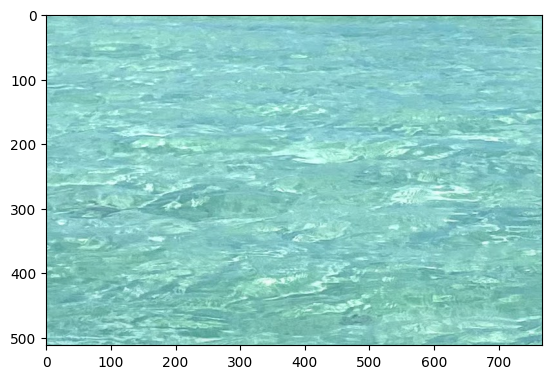

In [85]:
# Read images
u_0 = np.copy(u)
u_1 = loadImage("tulum.jpg")
u_1 = u_1[:u_0.shape[0], :u_0.shape[1]]

u_0_processed, mean_u0 = ChangeToPeriodic_Color(u_0)
u_1_processed, mean_u1 = ChangeToPeriodic_Color(u_1)

plt.imshow(u_0_processed)
plt.imshow(u_1_processed)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

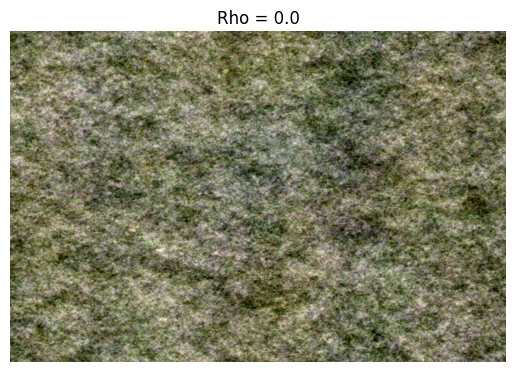

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

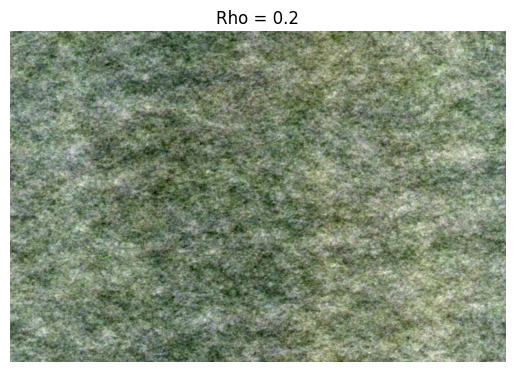

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

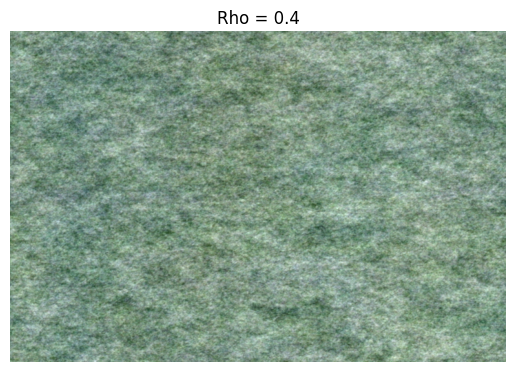

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

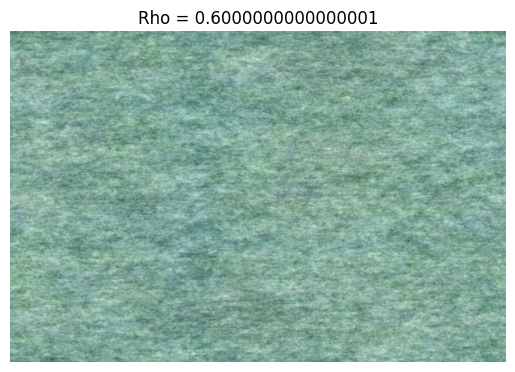

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

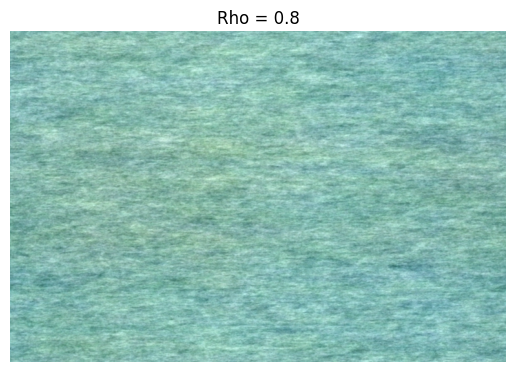

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

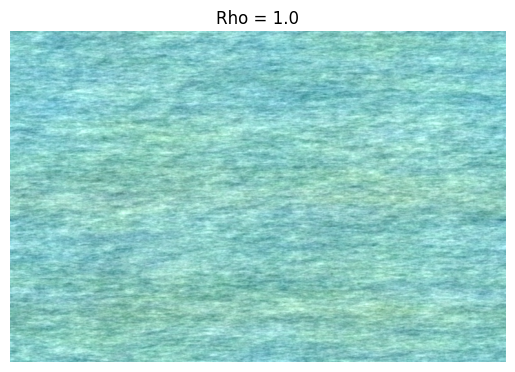

<IPython.core.display.Javascript object>

In [108]:
# Read images
u_0 = np.copy(u)
u_1 = loadImage("tulum.jpg")
u_1 = u_1[:u_0.shape[0], :u_0.shape[1]]

# Rho
n_p = 5

def GaussianTextureMixing_color(u_0, u_1, n_p):

    rho = [i/n_p for i in range(n_p + 1)]

    mean_u0 = np.mean(u_0, axis = (0,1))
    mean_u1 = np.mean(u_1, axis = (0,1))

    fft_u0_r = np.fft.fft2(u_0[:,:,0])
    fft_u0_g = np.fft.fft2(u_0[:,:,1])
    fft_u0_b = np.fft.fft2(u_0[:,:,2])

    fft_u1_r = np.fft.fft2(u_1[:,:,0])
    fft_u1_g = np.fft.fft2(u_1[:,:,1])
    fft_u1_b = np.fft.fft2(u_1[:,:,2])

    inter_r = np.vdot(fft_u1_r, fft_u0_r)
    inter_r /= np.abs(inter_r)

    inter_g = np.vdot(fft_u1_g, fft_u0_g)
    inter_g /= np.abs(inter_g)

    inter_b = np.vdot(fft_u1_b, fft_u0_b)
    inter_b /= np.abs(inter_b)

    output = []
    for rh in rho:
      mix_r = np.fft.ifft2((1-rh)*fft_u0_r + rh*inter_r*fft_u1_r).real[:,:,None]
      mix_g = np.fft.ifft2((1-rh)*fft_u0_g + rh*inter_g*fft_u1_g).real[:,:,None]
      mix_b = np.fft.ifft2((1-rh)*fft_u0_b + rh*inter_b*fft_u1_b).real[:,:,None]
      mix = np.concatenate((mix_r, mix_g, mix_b), axis = -1)
      mix -= np.mean(mix, axis = (0,1))
      output += [GenerateGaussianTexture_Color(mix, (1-rh)*mean_u0 + rh*mean_u1)]

    return output

# Get a list of texture mixing with differents values of rho
Grho_list = GaussianTextureMixing_color(u_0, u_1, n_p)

# Compare images
compare_images(Grho_list, n_p, gray=False)